In [2]:
import velvetvae as vt

# general packages
import numpy as np
import pandas as pd
import torch
from scipy.sparse import issparse

# velocity packages
import scanpy as sc
import scvelo as scv
import anndata as ann

# plotting packages
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
from IPython.display import clear_output


In [3]:
import os

In [23]:
adata = sc.read_h5ad('../SVM23/data/pilot_protocol_comparison.h5ad')
adata.obs_names_make_unique()

In [8]:
treat = adata[adata.obs.protocol=='old']
c_dict = {}
for cat in ['FT','DI', 'IO', 'NT']:
    sub = treat[treat.obs.treatment==cat]
    umi = np.array(sub.layers['total'].sum(1)).flatten()
    c_dict[cat] = umi
    
cond = []
umis = []
for key, val in c_dict.items():
    umi_clipped = np.clip(val, np.percentile(val, 1), np.percentile(val, 99))
    cond.extend([key]*len(umi_clipped))
    umis.extend(umi_clipped)
    
l_dict = {}
for cat in ['FT','DI', 'IO', 'NT']:
    sub = treat[treat.obs.treatment==cat]
    lab = np.array(sub.layers['labeled_TC'].sum(1)).flatten() / np.array(sub.layers['total'].sum(1)).flatten() 
    l_dict[cat] = lab
    
cond = []
labs = []
for key, val in l_dict.items():
    lab_clipped = np.clip(val, np.percentile(val, 1), np.percentile(val, 99))
    cond.extend([key]*len(lab_clipped))
    labs.extend(lab_clipped)

In [25]:
new_mols = np.array(umis) * np.array(labs)

In [26]:
df = pd.DataFrame({"Condition":cond,"Labelled Molecules":new_mols})


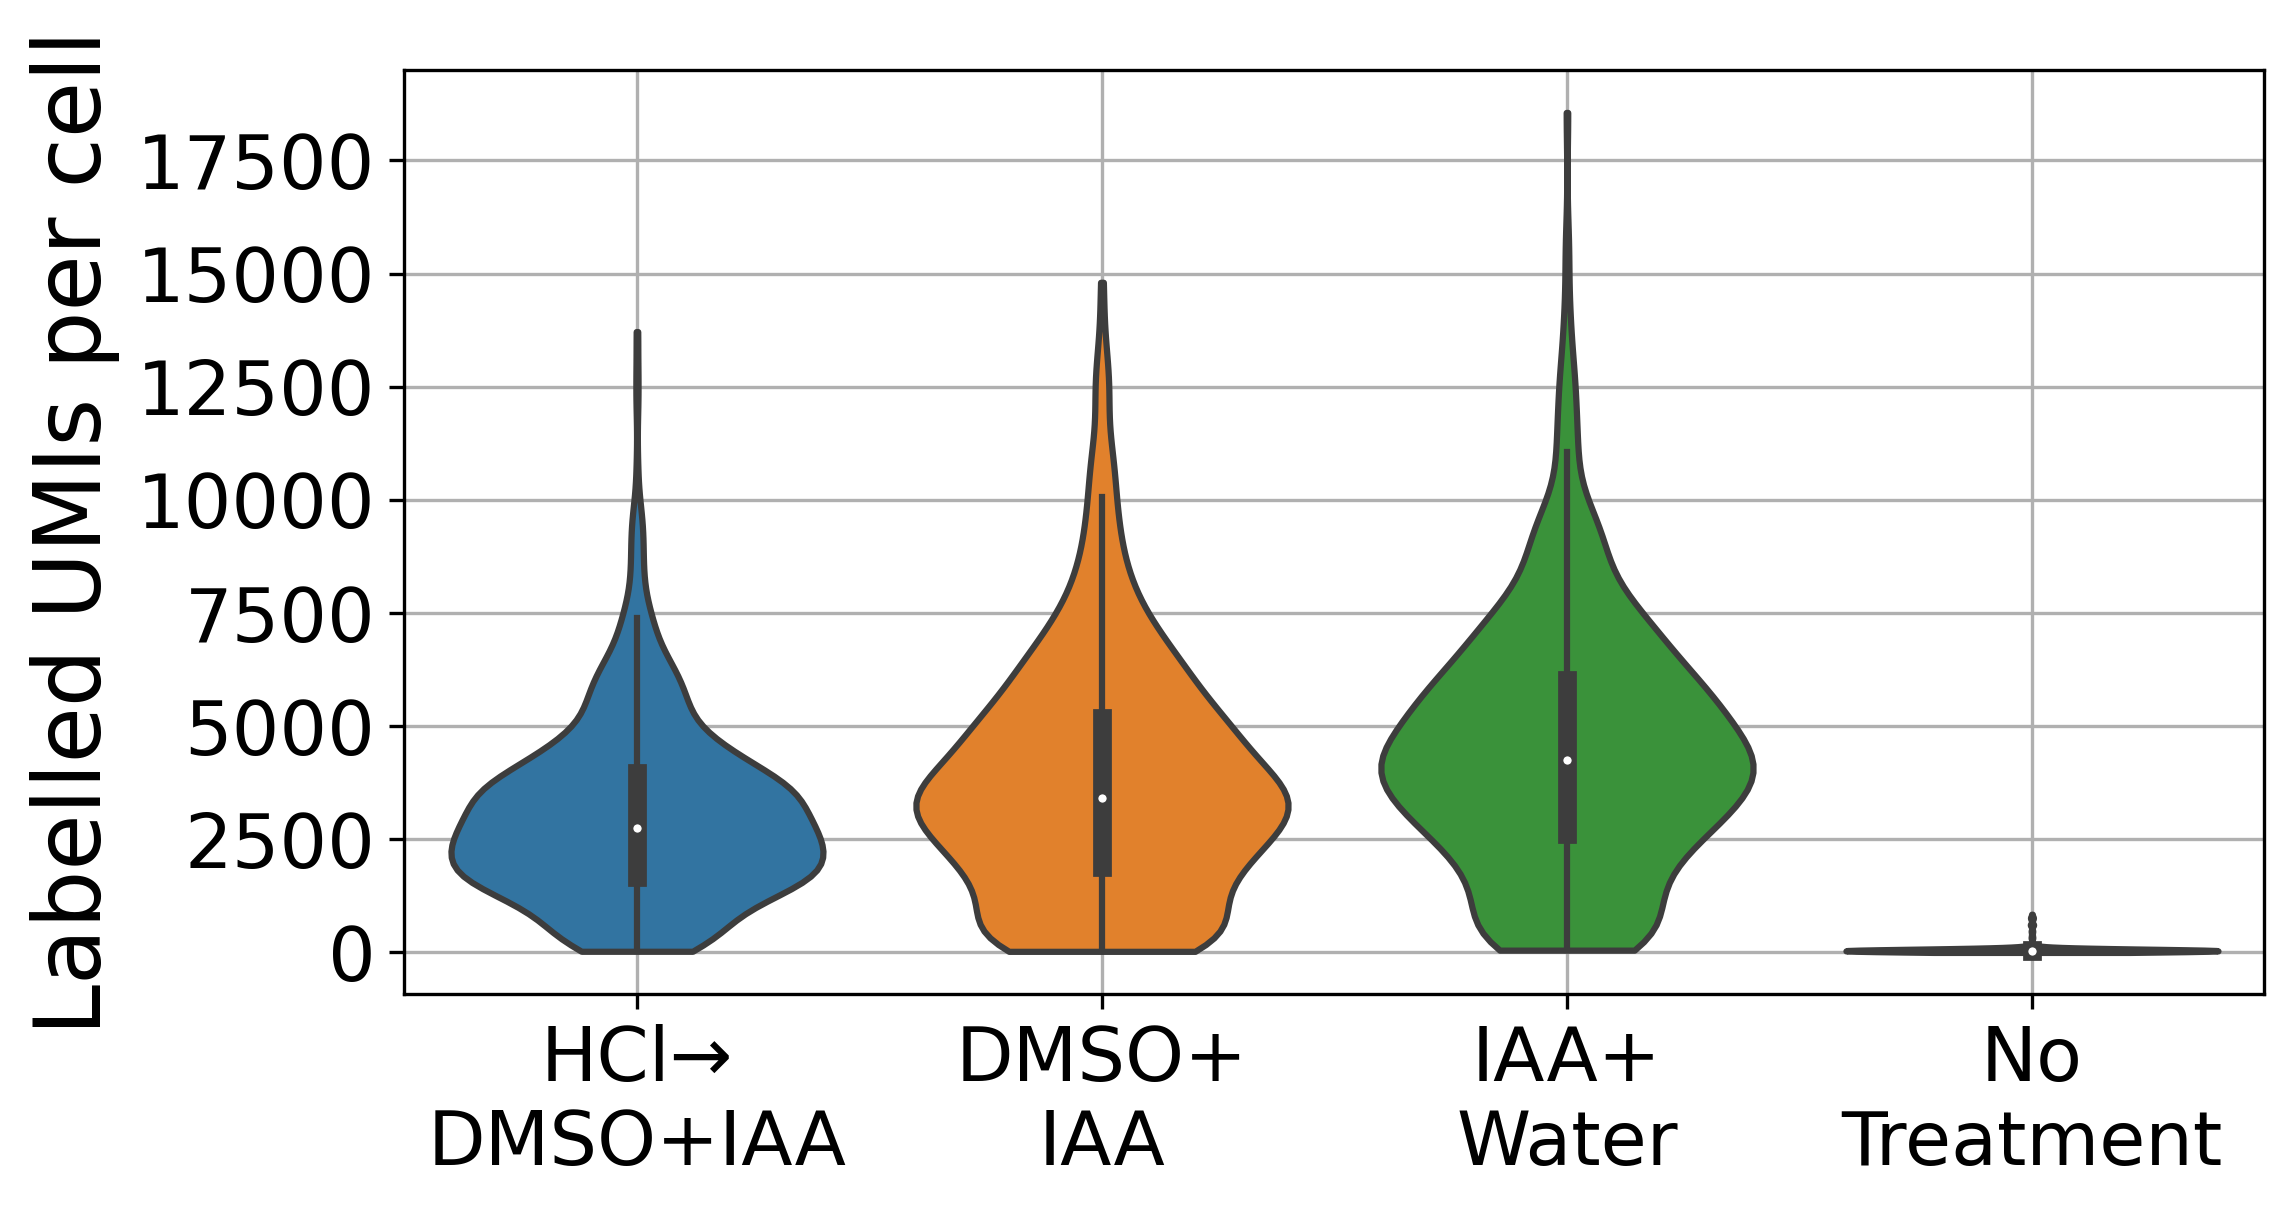

In [36]:
plt.figure(figsize=(8,4), dpi=300)

# Capture the axes object returned by sns.violinplot
ax = sns.violinplot(y="Labelled Molecules", x="Condition", data=df, cut=0, scale='width')

# Adjust axes and labels
plt.xticks([0,1,2,3], labels=["HCl→\nDMSO+IAA",'DMSO+\nIAA','IAA+\nWater','No\nTreatment'], rotation=0, fontsize=18)
plt.xlabel("")
plt.yticks(fontsize=18)
plt.ylabel("Labelled UMIs per cell", fontsize=22)

# Make grid visible and set behind other elements
ax.grid(True)
ax.set_axisbelow(True)

# Set the plot scales and other properties
# plt.yscale('log')
ax.set_facecolor('white')
plt.savefig("9_pilotimage.png", bbox_inches='tight')
plt.show()

In [49]:
p_dict = {}

  
prot = adata[adata.obs.treatment=='IO']
sub = prot[prot.obs.protocol=='old']
umi = np.array(sub.layers['total'].sum(1)).flatten()
gen = np.array((sub.layers['total']>0).sum(1)).flatten()
p_dict['scifate'] = (umi,gen)

prot = adata[adata.obs.treatment=='NT']
for p in ['old', 'pub','zym']:
    sub = prot[prot.obs.protocol==p]
    umi = np.array(sub.layers['total'].sum(1)).flatten()
    gen = np.array((sub.layers['total']>0).sum(1)).flatten()
    p_dict[p] = (umi,gen)

cond = []
umis = []
gens = []
for key, val in p_dict.items():
    umi, gen = val
    cond.extend([key]*len(umi))
    umis.extend(umi)
    gens.extend(gen)
df = pd.DataFrame({"Condition":cond,"UMIs":umis,"Genes":gens})

df

,Condition,UMIs,Genes
0,scifate,24663.0,6560
1,scifate,27174.0,6625
2,scifate,23531.0,5990
3,scifate,26686.0,6855
4,scifate,35492.0,7160
...,...,...,...
3110,zym,29917.0,6800
3111,zym,27422.0,6311
3112,zym,8888.0,3521
3113,zym,26885.0,6363


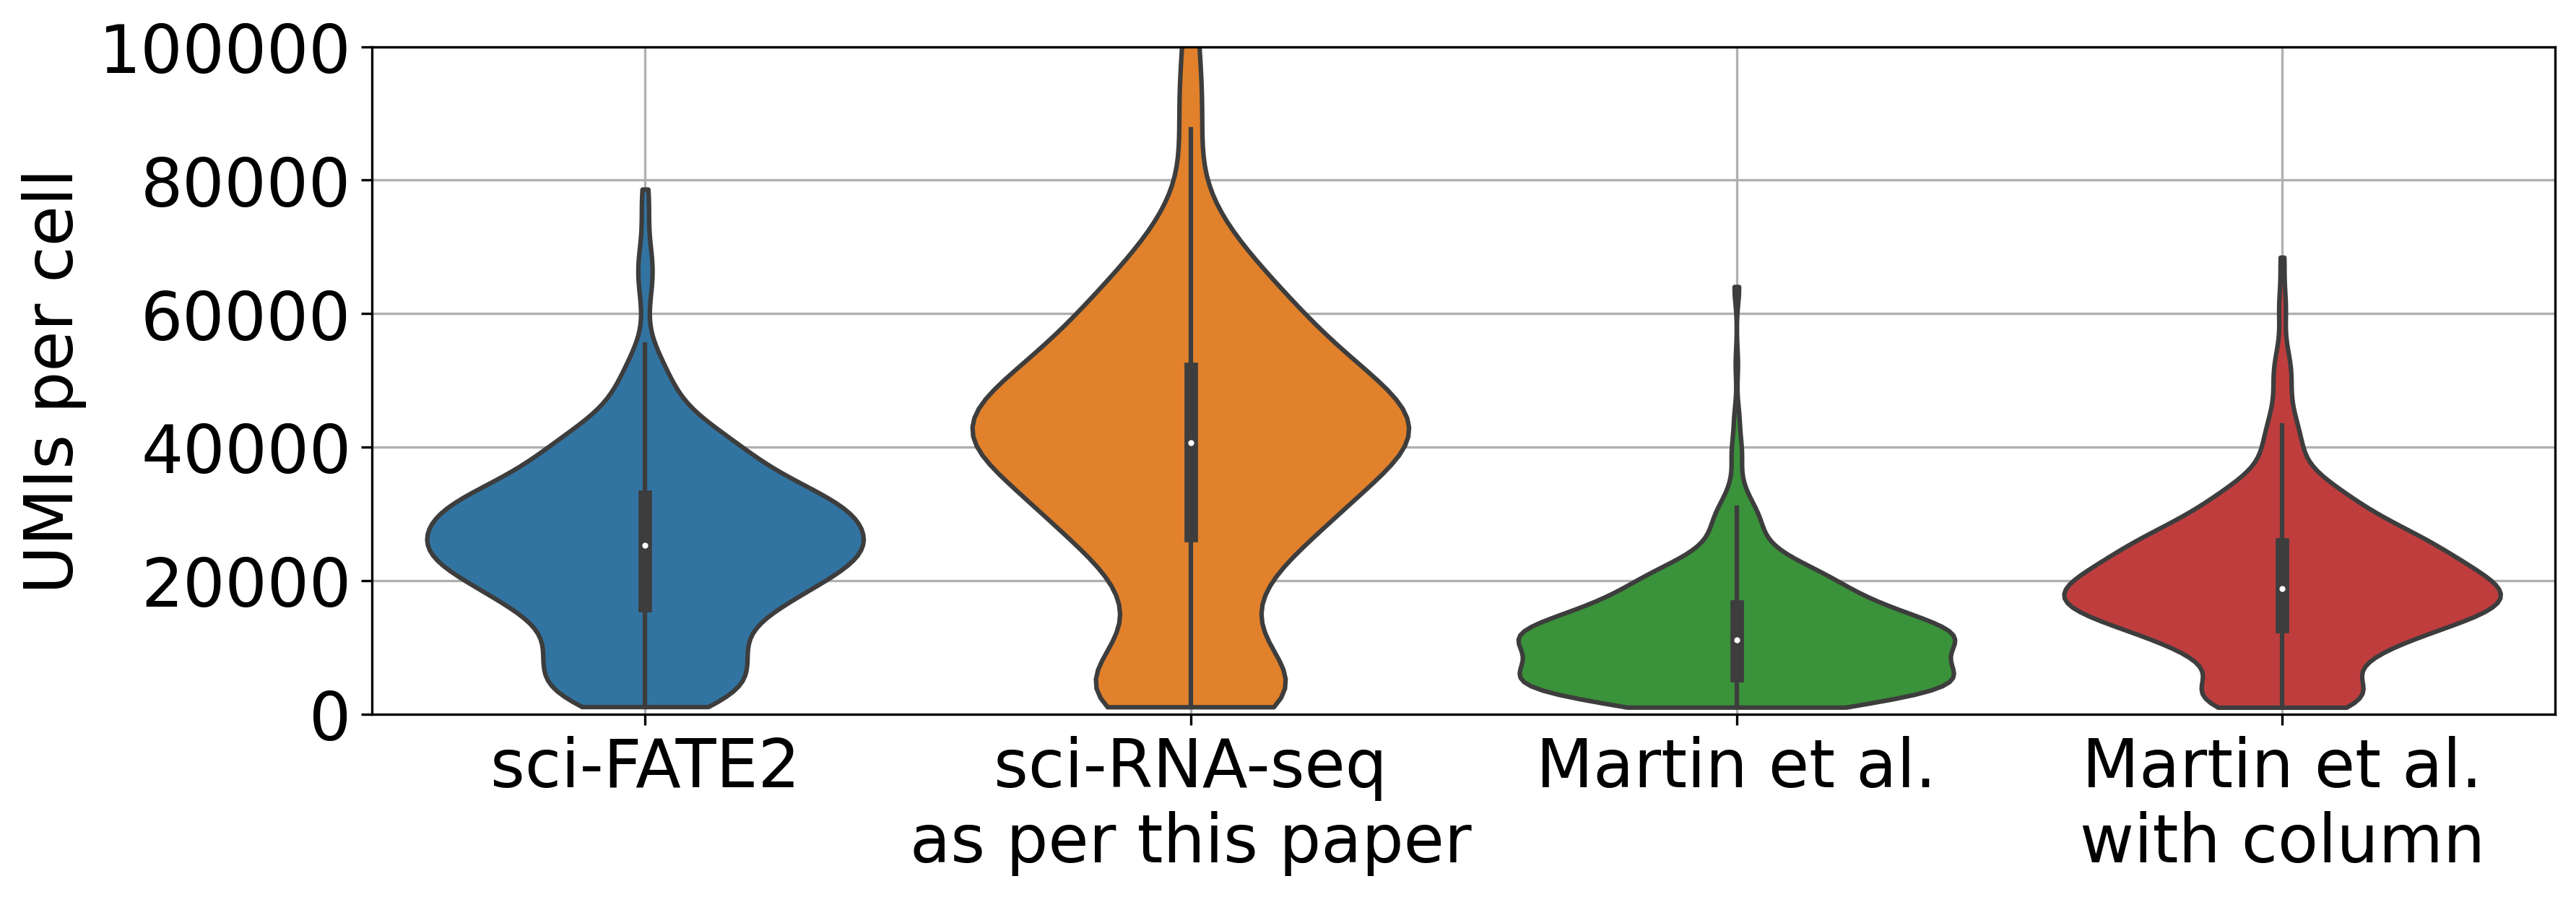

In [59]:
labels=['sci-FATE2','sci-RNA-seq\nas per this paper','Martin et al.', 'Martin et al.\nwith column']

plt.figure(figsize=(13,4), dpi=300)
ax = sns.violinplot(data=df, x='Condition',y='UMIs', scale='width', cut=0)
plt.xticks([0,1,2,3], labels=labels,
           rotation=0, fontsize=22)
plt.xlabel("")
plt.yticks(fontsize=22)
plt.ylabel("UMIs per cell", fontsize=22)
plt.ylim((0,100000))

for fig in plt.get_fignums():
    fig = plt.figure(fig)
    # Set the figure facecolor to transparent
    fig.patch.set_facecolor('none')

    # Loop over the axes in the figure
    for ax in fig.get_axes():
        # Set the axes facecolor to white
        ax.set_facecolor('white')
        
ax.grid(True)
ax.set_axisbelow(True)
plt.savefig("9_pilot2.png", bbox_inches='tight')
plt.show()

In [60]:
%%time

mus_path = "/nemo/lab/briscoej/home/users/maizelr/transcriptomics/mouse_transcriptomics_data/full_data/mouse_full_typed_velocity.loom"
hum_path = "/nemo/lab/briscoej/home/users/maizelr/transcriptomics/human_transcriptomics_analysis/data/human_full_typed_velocity.loom"
mdata = sc.read_loom(mus_path)
hdata = sc.read_loom(hum_path)

CPU times: user 2min 21s, sys: 21.3 s, total: 2min 42s
Wall time: 3min 38s
